# Exploring the data, basic fitting and visualization

#### Handle the imports

In [12]:
#First import the standard toolboxes
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from scipy.stats import zscore
from tqdm import tqdm

#Import the specific functions for this class
import encoding_tools

#Import some sklearn functions
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score


#### Download the data from the gdrive and load it

In [13]:
data_file = encoding_tools.download_neural_data("miniscope") #Download function from io
data_dict = np.load(data_file, allow_pickle = True).tolist()

#Create a variable for each keyword in the dictionary
for key,val in data_dict.items():
        exec(key + '=val')


Downloading...
From (uriginal): https://drive.google.com/uc?id=1JT0TcbWDKsB90CRMy0XX8dCSaO7Dxvi8
From (redirected): https://drive.google.com/uc?id=1JT0TcbWDKsB90CRMy0XX8dCSaO7Dxvi8&confirm=t&uuid=f059ed67-57d9-4aff-b2fe-baf43a9f61fd
To: C:\Users\Lukas Oesch\Documents\ChurchlandLab\DataSAI_data_folder\miniscope_data.npy
100%|█████████████████████████████████████████████████████████████████████████████| 1.30G/1.30G [00:37<00:00, 34.3MB/s]


#### What are these data?

The data we have loaded were obtained from a mouse performing a 2AFC task discriminating between high-frequency (> 12 Hz) and low-frequency (< 12 Hz) click trains. We recorded excitatory neurons in the anterior cingulate cortex of this mouse during the task performance while video tracking the animal's movements. What do the indiviudal variables mean?

<ul>
    <li> <strong>desing_matrix</strong>: This is the heart of the encoding model we are going to build. It contains a set of task and movement variables aligned to four distinct phases of the task, size is number of total frames x regressor number.</li>
 <li><strong>Y_raw_fluorescence</strong>: The fluorescence traces from all the neurons recorded algined to the same task phases as the task- and movement variables, size is number of total frames x neuron number</li>
 <li><strong>neuron_footprints</strong>: The spatial filters for the recorded neurons, size is 300 pixels x 300 pixels x neuron number. </li>
 <li><strong>timepoints_per_trial</strong>: The number of frames per trial.</li>
  <li><strong>frame_rate</strong>: The acquisition frame rate for the miniscope data.</li>
  <li><strong>aligned_segment_start</strong>: Marks the frames where the activity was aligned to a new task event. These also mark different task phases: Timepoints 0 to aligned_segment_start[0] contains the 1 second prior to trial initiation, the next phase is the 1 second from stimulus onset followed by action phase spanning from 200 ms before to 300 ms after movement onset and finally the outcome phase with 2 seconds after outcome presentation. The reason why the trial is split up into these phases is that there are variable delays before and after stimulus presentation and the choice report also happens at different speed.</li>
 </ul>


## Exercise 1: What is the structure of the design matrix?

Lets start by looking at the task variables inside the design matrix:

<ul>
    <li>time (the intercept per trial timepoint)</li>
    <li>choice (left = 0, right = 1)</li>
    <li>stimulus strength</li>
    <li>outcome (incorrect = 0, correct = 1)</li>
    <li>previous choice  (left = 0, right = 1)</li>
    <li>previous outcome (incorrect = 0, correct = 1)</li>
</ul> 

Let's  print some of the keys of the data frame and plot the task variable columns!

Index(['time_t0', 'choice_t0', 'stim_strength_t0', 'outcome_t0',
       'previous_choice_t0', 'previous_outcome_t0'],
      dtype='object')


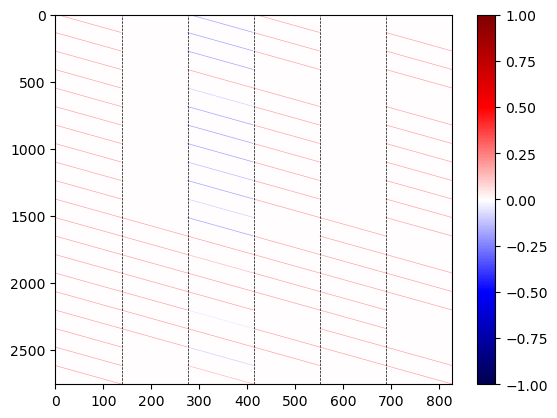

In [14]:
#Print some of the keys of the design matrix
print(design_matrix.keys()[np.arange(0,6 * timepoints_per_trial, timepoints_per_trial)])

#Plot the task variables
plt.figure()
plt.imshow(np.array(design_matrix)[:20 * timepoints_per_trial,:6 * timepoints_per_trial], aspect = 'auto', cmap = 'seismic')
#use np.array() on the design_matrix to be able to index numerically instead of by key
for k in range(6):
    plt.axvline(k * timepoints_per_trial, color='k', linestyle='--', linewidth=0.5)
plt.colorbar()

######---Try answering the following questions:
# Does the t0 on the keys mean?
# Why is the first column bounded by dashed lines all diagonals?
# Why are the other ones not all diagonals?
# What do negative values along the diagonal indicate?

## Exercise 2: How do task variables affect the activity of ACC neurons?

The aim of this exercise is to plot peri-event time histograms (PETHs) for two neurons for different choices and outcomes. 

<ol>
    <li> Extract the choice and outcomes for each trial from the design matrix. </li>
    <li> Reshape the response matrix, Y_raw_fluorescence, to be a 3-dimensional array refelcting time, neuron id and trial number. </li>
    <li> Complete the missing lines of code in the function that calculates and plots the mean +/- sem trace for a respective binary value of a task variable </li>
</ol>

In the following we will focus on the encoding of task variables by <strong>neuron 56</strong> and <strong>neuron 12</strong>. Let's first see how these cells look like.

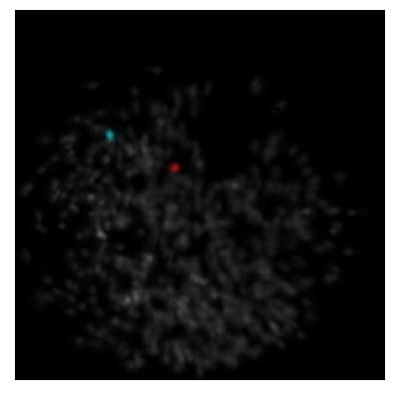

In [4]:
#Show the two example neurons: neuron 56 in red and neuron 12 in cyan superimposed on top of all the other identified cells (gray scale)
encoding_tools.overlay_neurons(neuron_footprints, 56, 12, 12) #Pass the neuron ids for the red, green and blue channel

Compare the PETHs for the two neurons. What do you think each neuron is responding to?
At which moment in time are the task variables represented differentially?


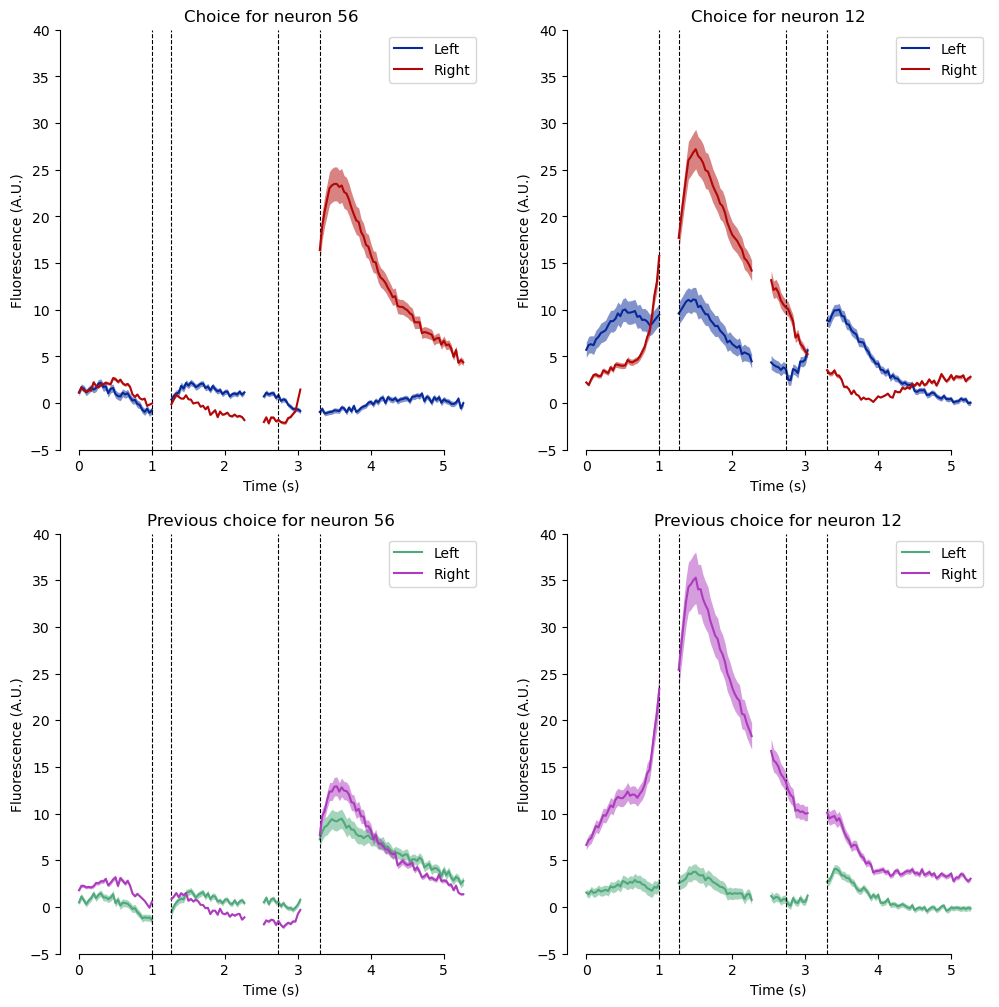

In [15]:
# 1. Extract choice and previous_choice for each trial from the design matrix: Use what you have learned about the
#    structure of the design matrix to generate a vector of choices and previous_choices, one entry per trial.

# TODO: Inser your code here

#######-------Solution--------------##################################################
#Linear indexing solution as a one-liner
choice = design_matrix['choice_t0'][np.arange(0, design_matrix.shape[0], timepoints_per_trial)]
previous_choice = design_matrix['previous_choice_t0'][np.arange(0, design_matrix.shape[0], timepoints_per_trial)]
#Important here: The start of the range has to correspond with the respective regressor timepoint. One could also
#use choice = design_matrix['choice_t1'][np.arange(0, design_matrix.shape[0], timepoints_per_trial)]

#Alternative: Looping through the first choice and outcome column jumping a block size each time
choice = []
previous_choice = []
for k in range(0, design_matrix.shape[0], timepoints_per_trial):
    #Here k loops through 0, 138, 276, ... because the task variable regressors are only valid in their respective time
    #if we loop through timepoint t0 (as we do because we start k at 0) we need to take the respective column in the pandas
    #data frame, here choice_t0.
    choice.append(design_matrix['choice_t0'][k])
    previous_choice.append(design_matrix['previous_choice_t0'][k])

#Convert to numpy arrays for convenience
choice = np.array(choice)
previous_choice = np.array(previous_choice)

#Note the choice and previous_choice are extracted from valid trials and they might not be sequential!
###################################################

# 2. Reshape the response matrix to obtain a timepoints x neuron id x trial array.

# TODO: Inset your code here

############----------Solution----------------------############
#Reshape and transpose
Y_3d = np.reshape(Y_raw_fluorescence.T, (Y_raw_fluorescence.shape[1], int(design_matrix.shape[0]/timepoints_per_trial), timepoints_per_trial)).transpose(2,0,1)
#This works the following way: reshape (when using C mode) takes sampes along the last axis of the input array first
#and adds them to the last axis of the output array. By first transposing the response matrix (.T notation) we make sure 
#that moving along axis 1 moves along the timepoints. By adding timepoints to the last axis of the new array and starting
#a new count of the second last axis after each trial we can construct first a 3d array where the axes initially are: 
#neuron id, trial, timepoint. By using transpose again and specifying the order of the axes we can recover a
#timepoints x neuron id x trials array.

#Alternative: loop through the timepoints
#######################################################

# 3. Please complete the function below that can be used to calculate and plot mean +/- sem traces for a specified neuron
#    and a specific binary task variable.

def plot_mean_trace(Y_3d, task_var, task_var_name, neuron_id, aligned_segment_start, ax, colors = ['#062999','#b20707'], spacer = 7, var_value_strings = ['Left', 'Right']):

    
    average_trace = np.stack((np.mean(Y_3d[:, neuron_id, task_var == 0],axis=1), np.mean(Y_3d[:, neuron_id, task_var == 1],axis=1))).T
# TODO: Similarly construct the sem_trace variable
    
#########-----Solution----------#######
    sem_trace = np.stack((np.std(Y_3d[:, neuron_id, task_var == 0],axis=1) / np.sqrt(np.sum(task_var == 0)),
                          np.mean(Y_3d[:, neuron_id, task_var == 1],axis=1) / np.sqrt(np.sum(task_var == 1)))).T
##############################################
    alignment_position_x_vect = [-1, 0, 6, 0] #These are the indices of the x_vect element where the alignment happend. 
    #Hard coded here, for simplicity.
    
    for n in range(average_trace.shape[1]): #Loop through the average traces
        for k in range(len(aligned_segment_start)): #Loop through the different task segments
            
            if k < len(aligned_segment_start) - 1 : #Split by different segments
                plot_idx = np.arange(aligned_segment_start[k], aligned_segment_start[k+1]) #Extract indices of the current segment
                x_vect = (plot_idx + k*spacer) / frame_rate #Create a time vector to plot the data to
                line_label = None 
            else:
                plot_idx = np.arange(aligned_segment_start[k], Y_3d.shape[0])
                x_vect = (plot_idx + k*spacer) /frame_rate
                line_label = var_value_strings[n] #only use a label on the last segment

# TODO: Plot the sem and the average traces of the respective segment agains the time vector
#       to the axes ax using fill_between and plot methods. Remember that we are not only looping
#       through aligned segments but also through task variable conditions (True or False).
#       As keyword arguments for fill_between use: color = colors[n], alpha = 0.5, linewidth = 0
#       As keyword aruments to plot use: color = colors[n], label = line_label

#################----------Solution--------##############################
            ax.fill_between(x_vect, average_trace[plot_idx,n] - sem_trace[plot_idx,n], average_trace[plot_idx,n] + sem_trace[plot_idx,n], color = colors[n], alpha = 0.5, linewidth=0)
            ax.plot(x_vect, average_trace[plot_idx,n], color = colors[n], label = line_label)
###########################################################################
            if n == 0: #Plot vertical alignment timepoints only once in the loop
                ax.axvline(x_vect[alignment_position_x_vect[k]], color = 'k', linewidth = 0.8, linestyle = '--')
            
    #Do some figure formating
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Fluorescence (A.U.)')
    ax.set_title(f'{task_var_name} for neuron {neuron_id}')
    ax.legend()
    ax.set_ylim([-5, 40]) #Pre-set for this data
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_bounds([ax.get_yticks()[0], ax.get_yticks()[-1]]) 
    ax.spines['bottom'].set_bounds([ax.get_xticks()[1], ax.get_xticks()[-2]]) #In this case the plotting is bounded by invisible ticks, thus 1 and -2
    return


#Now lets call our function and plot the traces!

#First create a figure with four subplots
axes_list = encoding_tools.create_subplot_axes(2, 2) #From visualizations

#Now we can fill the subplots
plot_mean_trace(Y_3d, choice, 'Choice', 56, aligned_segment_start, axes_list[0])
plot_mean_trace(Y_3d, choice, 'Choice', 12, aligned_segment_start, axes_list[1])
plot_mean_trace(Y_3d, previous_choice, 'Previous choice', 56, aligned_segment_start, axes_list[2], colors = ['#4fa97a', '#ac3cbd'])
plot_mean_trace(Y_3d, previous_choice, 'Previous choice', 12, aligned_segment_start, axes_list[3], colors = ['#4fa97a', '#ac3cbd'])

print('Compare the PETHs for the two neurons. What do you think each neuron is responding to?\nAt which moment in time are the task variables represented differentially?')

#### Prepare for model fitting

Here, we will set the inputs and outouts up for the following hyperparameter optimization and the model fitting and performance evaluation. We will need to z-score the response matrix, Y_raw_fluorescence, and the design_matrix as well. The latter one is extremely important to make sure that the different regressors are measured on the same scale, so all regressors get a fair chance to explain variance. However, here, we choose not to z-score 1) the sin and cos of the head orientation angles because independent z-scoring would abolish their relation and thus remove angle information 2) the binary task variables because leaving them in their binary form preserves the interpretability of the model. <br>
<strong>Can you imaginge why this is?<strong/>

In [16]:
#z-score the response matrix
Y = zscore(Y_raw_fluorescence)

#z-score the respective column of the design matrix
scaler_obj = encoding_tools.standardize_x_cols(column_idx = np.arange(832, 1258)).fit(design_matrix) #Cols 0:827 are task vars, cols 828:832 are head orientation
X = scaler_obj.transform(design_matrix)
#Note: this class is defined in utils. It contains a fit and transform method, similar to StandardScaler from sklearn.preprocessing
#We'll get back to this below

## Exercise 3: Estimating the reularization strength of the model

As you have seen in the teaching modules and notebook No 1: <strong>1_Regression_Basics</strong> the regularization strength (we use sklearn convention and call it alpha here) controls the shrinkage of the regressor weights and is critical to prevent overfitting. In this notebook we will use the sklearn class RidgeCV. RidgeCV searches through a grid of provided candidate alphas and determines the best alpha value using a built-in leave-one-out corss validation. <br>
In the following exercise you will be asked to:
<ol>
    <li> Choose appropriate parameters <strong>fit_intercept</strong> and <strong>alphas_per_target</strong> for RidgeCV.</li>
    <li> Perform the grid search.</li>
    <li> Retrieve the found regularization strengths as <strong>alphas</strong>.</li>
</ol>

Text(0, 0.5, 'Count')

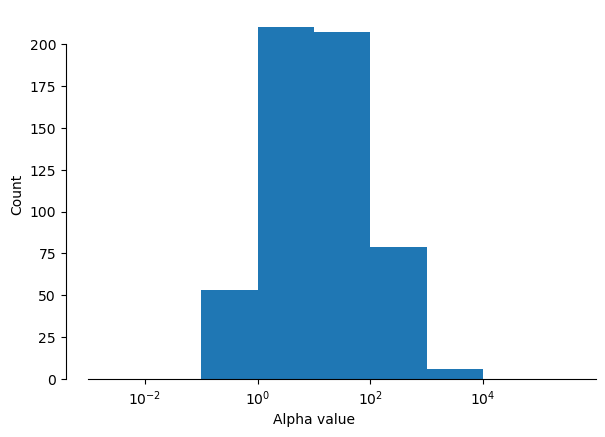

In [17]:
#Define an exponentially growing search grid here
test_range = test_range = 10**np.linspace(-3,5,9) #Get search values for alpha on log scale

# 1. Define the RidgeCV paramters fit_intercept and alphas_per_target and explain why you chose them

# TODO: Insert your code and explanations here

##########################-----Solution----############3
fit_intercept = False #The model contains an intercept term already, the time regressor!
alpha_per_target = True #Allow every neuron to be regularized individualy for better model performance
####################################################################################

# 2. Perform the grid search on the provided arrays X and Y

# TODO: Insert your code here

#########-------------Solution----------###############################################################
ridge_grid_search = RidgeCV(alphas = test_range, fit_intercept = fit_intercept, alpha_per_target = alpha_per_target, cv=None, scoring='r2').fit(X,Y)
#######################################################################################################

# 3. Retrieve alpha values

# TODO: Insert your code here
####################--------Solution---------##################
alphas = ridge_grid_search.alpha_
#######################################################

#Plot histogram of the alpha values
ax = plt.figure().add_subplot(111)
ax.hist(alphas, bins = test_range)
ax.set_xscale('log')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_bounds([0,200])
ax.spines['bottom'].set_bounds([10**-3, 10**6])
ax.set_xlabel('Alpha value')
ax.set_ylabel('Count')

#### Draw the samples for the 10-fold cross-validation

In [18]:
k_folds = 10 # To do 10 fold cross-validation
kf = KFold(n_splits = k_folds, shuffle = True) 
k_fold_generator = kf.split(design_matrix, Y_raw_fluorescence) #This returns a generator object that spits out a different split at each call
training = []
testing = []
for draw_num in range(k_folds):
    tr, te = k_fold_generator.__next__()
    training.append(tr)
    testing.append(te)
    

## Exercise 4: Assemble a pipeline for data preprocessing and model fitting with the found regularization strengths, alpha

For this exercise you will implement a pipeline to fit ridge models for the 10 splits of the data and evaluate the performance of each of them. 
<ol>
    <li> Set up a pipline that first uses encoding_tools.standardize_x_cols to calculate the mean and std of the respective columns in the training data set only and then apply them to training and testing data for z-scoring, and second fit the ridge model. Store the pipeline as <strong>pipe</strong>.</li>
    <li> Use the pipeline to fit the model on the training data with the output <strong>fits</strong> and predict the testing data, retrieving <strong>predictions</strong>.</li>

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:14<00:00, 25.48s/it]


Text(70, 0.66, 'Neuron 56 and neuron 12')

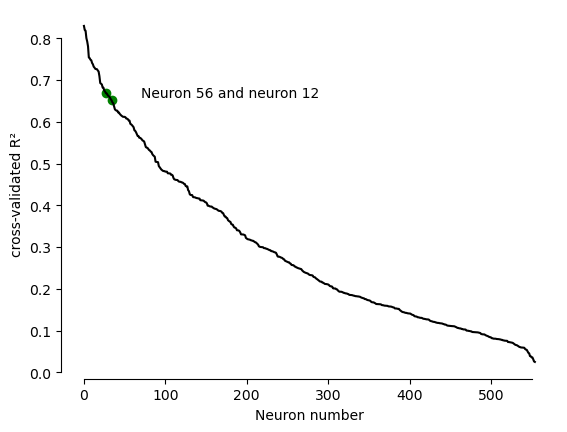

In [19]:
#Start by setting up the parameters of the model
ridge_model = Ridge(alpha = alphas, fit_intercept = fit_intercept) #We still have fit_intercept from the alpha search...
X = np.array(design_matrix) #convert to array to facilitate indexing

#Set up the lists for beta weights and coefficient of determination of all the 10 models
betas = []
r_squared = []

# 1. Create the pipeline for the fitting below. The pipeline should contain a 'scaler' step that calls standardize_x_cols
#    and a ridge step that fits the model.

# TODO: Insert your code here

###########################-----Solution-------------------####################
pipe = Pipeline(steps=[('scaler', encoding_tools.standardize_x_cols(column_idx = np.arange(832, 1258))), ('ridge', ridge_model)])
#####################################################################

#Start looping through the folds
for k in tqdm(range(k_folds)):
    
# 2. Fit the training data sets using the pipleline and retrieve the result as fits. Then predict the unseen testing data
#    with the pipeline and store the results as predictions

# TODO: Insert your code here
################----------Solution-------------##################################
    fits = pipe.fit(X[training[k],:], Y[training[k],:]) #Actually the fits wouldn't even need to be stored as a variable because they can be accessed from the pipeline
    predictions = pipe.predict(X[testing[k],:])
#################################################################################

    r_squared.append(r2_score(Y[testing[k],:], predictions, multioutput = 'raw_values'))
    betas.append(pipe['ridge'].coef_)
    
betas = np.squeeze(betas)
r_squared = np.squeeze(r_squared)

#Plot the sorted r_squared values
average_r2 = np.mean(r_squared, axis=0)
idx = np.flip(np.argsort(average_r2)) #argsort returns the indices of the sorted array and flip reverts the order
example_neuron_idx = [np.where(idx==56)[0][0], np.where(idx==12)[0][0]]

ax = plt.figure().add_subplot(111)
ax.plot(average_r2[idx], color = 'k')
ax.scatter(example_neuron_idx, average_r2[[56,12]], color = 'g')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_bounds([0,0.8])
ax.spines['bottom'].set_bounds([0,550])
ax.set_xlabel('Neuron number')
ax.set_ylabel('cross-validated R\u00b2') 
ax.text(70, 0.66, 'Neuron 56 and neuron 12')


## Exercise 5: Plot the choice and previous choice encoding over the trial duration as estimated by the encoding model

The aim of the final exercise of this notebook is to visualize the estimated weights for the previous choice and choice regressors across trial time.
<ol>
    <li> Average the beta weights of the different fold to generate the mean weights as <strong>average_beta</strong>.</li>
    <li> Using what you've learned about the structure of the design matrix retrieve the beta weights for choice and previous choice over the trial duration as <strong>choice_betas</strong> and <strong>previous_choice_betas</strong>.</li>
    <li> Compare the compare the obtained plots and also look again at the plots from exercise 2. Discuss the questions printed above the plots.</li>
</ol>

Why are the lines labeled Intercept and Right choice / Previous right choice on these plots?
What is the interpretation of these lines and how would you reconstruct a PETH for a right choice trial from the regressor weights?
Do these neurons mix encoding of different task variables?
How are these plots different from the ones in exercise 2? Do the plots below suggest different task variable encoding?


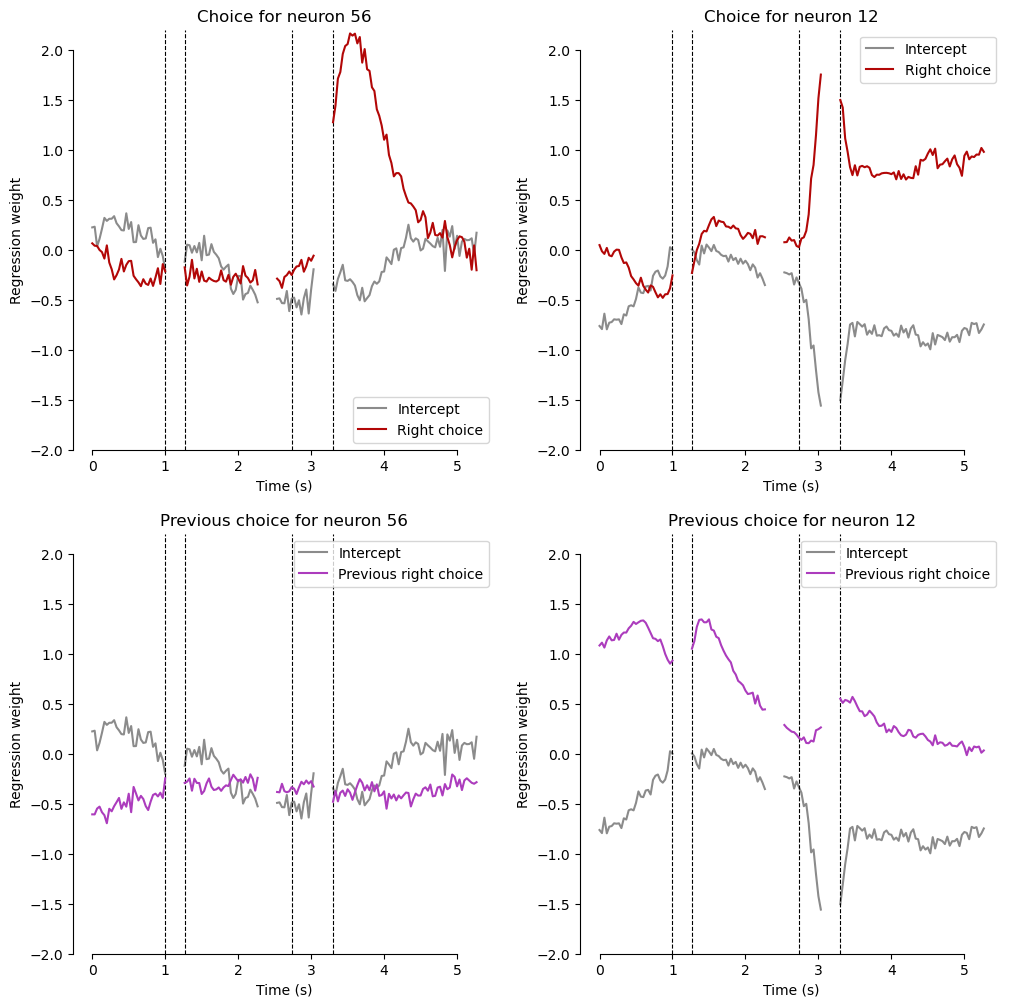

In [23]:
# 1. Start by getting the average beta weights

# TODO: Insert your code here

#####################------------Solution-----#######################
average_beta = np.mean(betas, axis=0) #Fold are along axis 0
######################################################################

# 2. Retrieve the betas for tiem, choice and previous choice and name them choice_betas and previous_choice_betas. Make sure
#    to build these varaibles so that the trial times are rows and the columns are neurons.

######################----------Solution-----------################
time_betas = average_beta[:, 0 : 1 * timepoints_per_trial].T
choice_betas = average_beta[:,timepoints_per_trial : 2*timepoints_per_trial].T
previous_choice_betas = average_beta[:,4*timepoints_per_trial : 5*timepoints_per_trial].T
###########################################################################################

#Reuse the plotting function from exercise 2
def plot_task_var_betas(task_var_betas, time_betas, task_var_name, neuron_id, aligned_segment_start, ax, colors = ['#062999','#b20707'], spacer = 7, var_value_strings = ['Left', 'Right']):
    
    beta_traces = np.stack((time_betas[:,neuron_id], task_var_betas[:,neuron_id]),axis=1)
    alignment_position_x_vect = [-1, 0, 6, 0] #These are the indices of the x_vect element where the alignment happend. 
    #Hard coded here, for simplicity.
    
    for n in range(beta_traces.shape[1]): #Loop through the average traces
        for k in range(len(aligned_segment_start)): #Loop through the different task segments
            
            if k < len(aligned_segment_start) - 1 : #Split by different segments
                plot_idx = np.arange(aligned_segment_start[k], aligned_segment_start[k+1]) #Extract indices of the current segment
                x_vect = (plot_idx + k*spacer) / frame_rate #Create a time vector to plot the data to
                line_label = None 
            else:
                plot_idx = np.arange(aligned_segment_start[k], beta_traces.shape[0])
                x_vect = (plot_idx + k*spacer) /frame_rate
                line_label = var_value_strings[n] #only use a label on the last segment
            ax.plot(x_vect, beta_traces[plot_idx,n], color = colors[n], label = line_label)
            
            if n == 0: #Plot vertical alignment timepoints only once in the loop
                ax.axvline(x_vect[alignment_position_x_vect[k]], color = 'k', linewidth = 0.8, linestyle = '--')
            
    
    #Do some figure formating
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Regression weight')
    ax.set_title(f'{task_var_name} for neuron {neuron_id}')
    ax.legend()
    ax.set_ylim([-2, 2.2]) #Pre-set for this data
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_bounds([ax.get_yticks()[0], ax.get_yticks()[-2]]) 
    ax.spines['bottom'].set_bounds([ax.get_xticks()[1], ax.get_xticks()[-2]]) #In this case the plotting is bounded by invisible ticks, thus 1 and -2
    return


#Now lets call our function and plot the traces!

#First create a figure with four subplots
axes_list = encoding_tools.create_subplot_axes(2, 2) #From visualizations

#Now we can fill the subplots
plot_task_var_betas(choice_betas, time_betas, 'Choice', 56, aligned_segment_start, axes_list[0], colors = ['#8b8b8b', '#b20707'], var_value_strings = ['Intercept', 'Right choice'])
plot_task_var_betas(choice_betas, time_betas, 'Choice', 12, aligned_segment_start, axes_list[1], colors = ['#8b8b8b', '#b20707'], var_value_strings = ['Intercept', 'Right choice'])
plot_task_var_betas(previous_choice_betas, time_betas, 'Previous choice', 56, aligned_segment_start, axes_list[2], colors = ['#8b8b8b', '#ac3cbd'], var_value_strings = ['Intercept', 'Previous right choice'])
plot_task_var_betas(previous_choice_betas, time_betas, 'Previous choice', 12, aligned_segment_start, axes_list[3], colors = ['#8b8b8b', '#ac3cbd'], var_value_strings = ['Intercept', 'Previous right choice'])

# 3. Discuss these questions:
print('Why are the lines labeled Intercept and Right choice / Previous right choice on these plots?')
print('What is the interpretation of these lines and how would you reconstruct a PETH for a right choice trial from the regressor weights?')
print('Do these neurons mix encoding of different task variables?')
print('How are these plots different from the ones in exercise 2? Do the plots below suggest different task variable encoding?')
      

## This is it for this notebook!

Many thanks to Adi Nair for putting together the DataSAI summer school program, Max Melin and Gabriel Rojas-Bowe for putting together the content of this class and Anne Churchland and the Churchland lab for their support and inputs.
